# EDA

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 

## Preparacion del dataframe para su analisis

In [2]:
steam = pd.read_json('../Datasets/Steam_Games_Limpio.json.gz', compression='gzip')
review = pd.read_json('../Datasets/User_Reviews_Limpio.json.gz', compression='gzip')
items = pq.read_table('Datasets OPS\items.parquet').to_pandas()

In [3]:
# Creamos una linea por item del usuario
items = items.explode('items', ignore_index=True)
itemsDeUsuario = pd.json_normalize(items['items'])
items.head()

,user_id,items_count,items
0,76561197970982479,277,"{'item_id': '10', 'item_name': 'Counter-Strike..."
1,76561197970982479,277,"{'item_id': '20', 'item_name': 'Team Fortress ..."
2,76561197970982479,277,"{'item_id': '30', 'item_name': 'Day of Defeat'..."
3,76561197970982479,277,"{'item_id': '40', 'item_name': 'Deathmatch Cla..."
4,76561197970982479,277,"{'item_id': '50', 'item_name': 'Half-Life: Opp..."


In [4]:
# borramos las filas donde tienen todos nulos, borramos playtime_2weeks ya que no me da informacion.
itemsDeUsuario.dropna(how='all', inplace=True)
itemsDeUsuario['item_id'] = itemsDeUsuario['item_id'].astype(int)
itemsDeUsuario.drop(columns='playtime_2weeks', inplace=True)

# Preparamos items para hacer un merge con los items ya en forma de dataframe.
items.dropna(subset='items', inplace=True)
items.drop(columns='items',inplace=True)

In [5]:
# Generamos un dataframe con toda la informacion junta, la de reviews al hacer el merge y la de items.
df = review.merge(items, on='user_id', how='left').drop_duplicates()
df.reset_index(drop=True, inplace=True)

items = pd.concat([items, itemsDeUsuario], axis=1)
df = df.merge(items.drop(columns='items_count'), on=['user_id','item_id'])

In [6]:
# Ya unidos los dataframes de items, y review, ahora juntamos con el de steam para tener toda la informacion junta para analisarla.
df = df.merge(steam, left_on='item_id', right_on='id')
df = df.drop(columns=['id','title'])
df[['playtime_forever','items_count']]=df[['playtime_forever','items_count']].astype(int)

In [7]:
# Cambiamos el tipo de recommend de bool a int
df['recommend'] = df['recommend'].astype('int8')
df.head()

,user_id,item_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever,genres,release_date,price,developer
0,76561197970982479,1250,1,2,277,Killing Floor,10006,[Action],2009,19.99,Tripwire Interactive
1,DJKamBer,1250,1,0,152,Killing Floor,2851,[Action],2009,19.99,Tripwire Interactive
2,diego9031,1250,1,1,200,Killing Floor,1204,[Action],2009,19.99,Tripwire Interactive
3,GamerFag,1250,1,2,64,Killing Floor,33723,[Action],2009,19.99,Tripwire Interactive
4,76561198092227136,1250,1,1,333,Killing Floor,8694,[Action],2009,19.99,Tripwire Interactive


In [ ]:
# Expotrtamos para su uso con el modelo de machine learning
df.to_json('EDA\EDA_Dataset.json.gz', compression='gzip')

## Comienzo del analisis

### Top 5 juego con mas horas jugadas (playtime_forever)

In [8]:
# Sacamos las horas del dataframe
juegoMasJugado = df[['item_name','playtime_forever']].groupby('item_name').sum()
# Agarramos el top 5
juegoMasJugado = juegoMasJugado['playtime_forever'].sort_values(ascending=False).head(5)

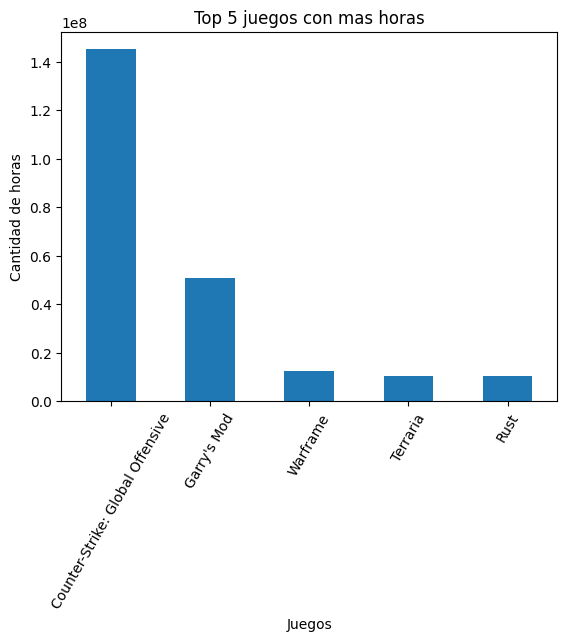

In [9]:
# Creamos el grafico
juegoMasJugado.plot(kind='bar')
plt.title('Top 5 juegos con mas horas')
plt.xlabel('Juegos')
plt.ylabel('Cantidad de horas')
plt.xticks(rotation=60)
plt.show()

### Analisis de price

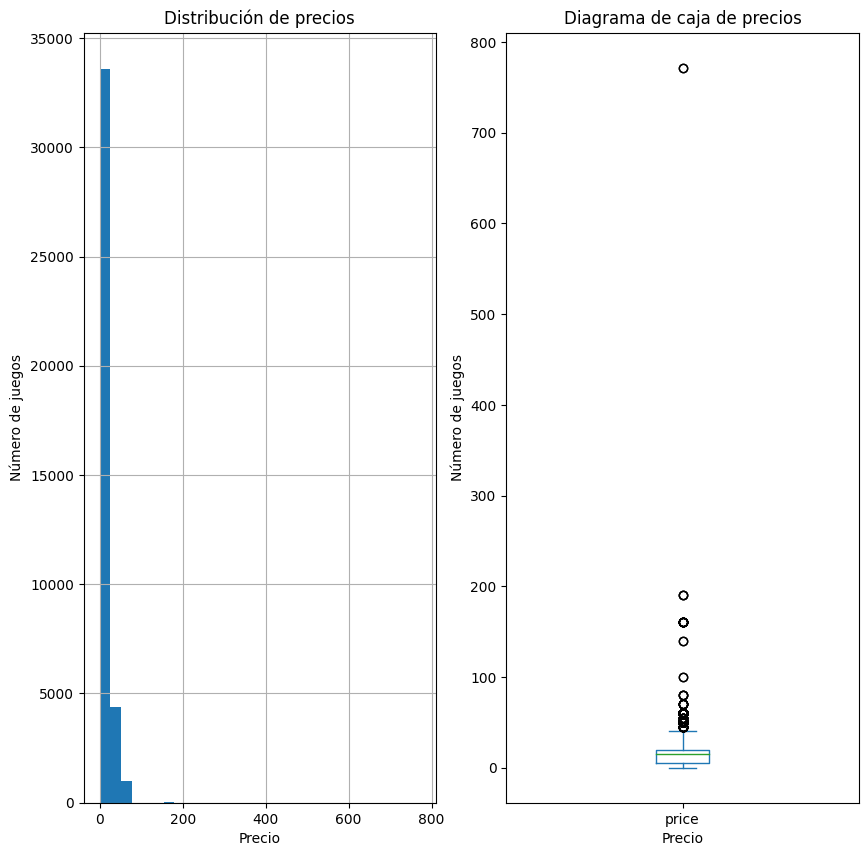

In [10]:
plt.subplot(1,2,1)
df['price'].hist(bins=30, figsize=(10, 10))
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Número de juegos')

plt.subplot(1,2,2)
df['price'].plot.box()
plt.title('Diagrama de caja de precios')
plt.xlabel('Precio')
plt.ylabel('Número de juegos')

plt.show()

### Analisis de generos

In [ ]:
# Agregar columnas al dataset para poder hacer el recuento de cada genero

#Vemos todos los generos de los juegos que tenemos
listaDeGeneros = []
for generos in df['genres']:
  for genero in generos:
    if genero not in listaDeGeneros:
      listaDeGeneros.append(genero)

# Los inicializamos en 0
df[listaDeGeneros] = 0

# Aplicamos un 1 en cada uno a cada juego que pertenece a X genero.
for indice, generos in enumerate(df['genres']):
  for genero in generos:
    df[genero].iloc[indice] = 1

#Basicamente hizmos unos dummies pero por le tipo de formato de como se enceuntra el dataset, pude hacerlo de esta forma.

#Guaradmos los datos en otro dataframe para que quede mas ordenado.
generos = []
cantidad = []
for genero in listaDeGeneros:
    generos.append(genero)
    cantidad.append(df[genero].value_counts()[1])

juegos = pd.DataFrame()
juegos['Genero'] = generos
juegos['Cantidad'] = cantidad

#### Cantidad total de juegos por genero

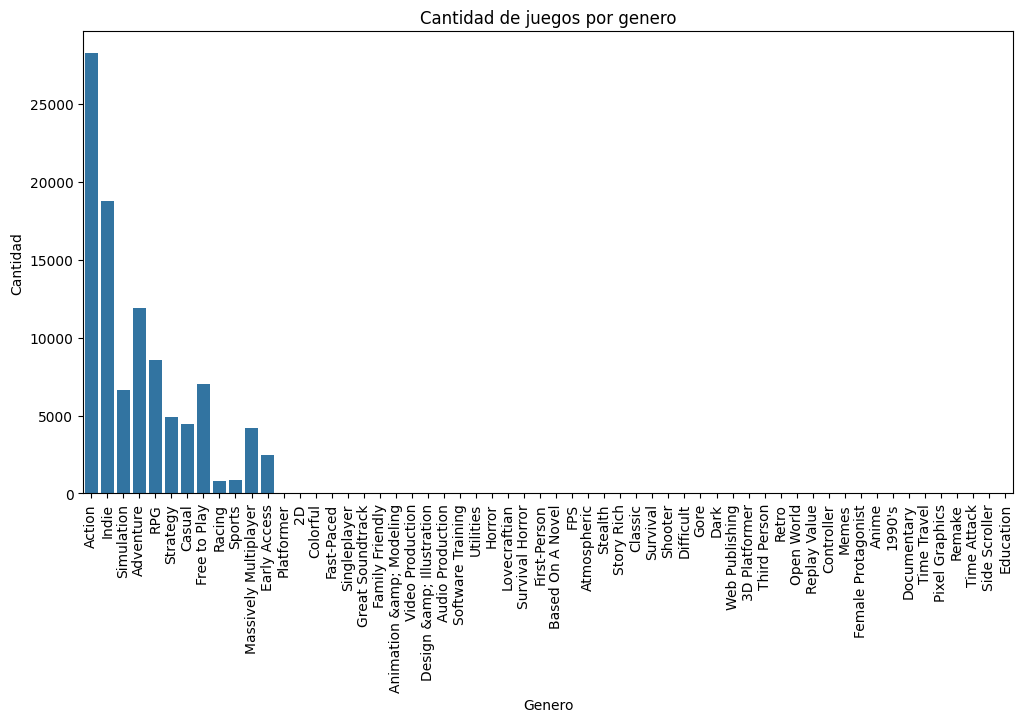

In [12]:
plt.figure(figsize=(12, 6)) 
sns.barplot(data=juegos, x='Genero', y='Cantidad')
plt.title('Cantidad de juegos por genero')
plt.xticks(rotation=90)
plt.show()

#### Top 5 de generos mas jugados

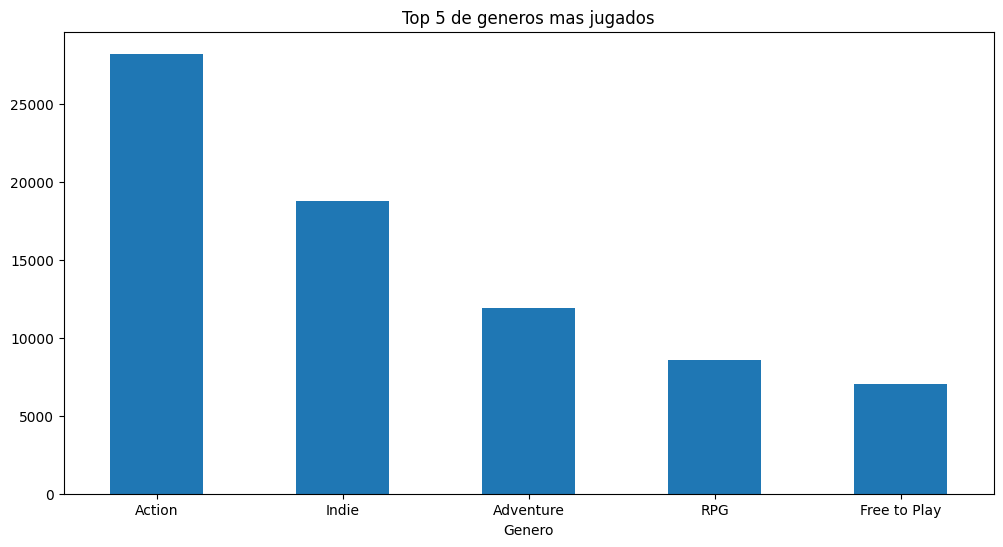

In [13]:
juegos = juegos.groupby('Genero').sum()['Cantidad'].sort_values(ascending=False).head(5)

# Graficamos
plt.figure(figsize=(12, 6)) 
juegos.plot(kind='bar')
plt.title('Top 5 de generos mas jugados')
plt.xticks(rotation=0)
plt.show()


df.drop(columns=listaDeGeneros, inplace=True)

### Cantidad de juegos lanzados por año

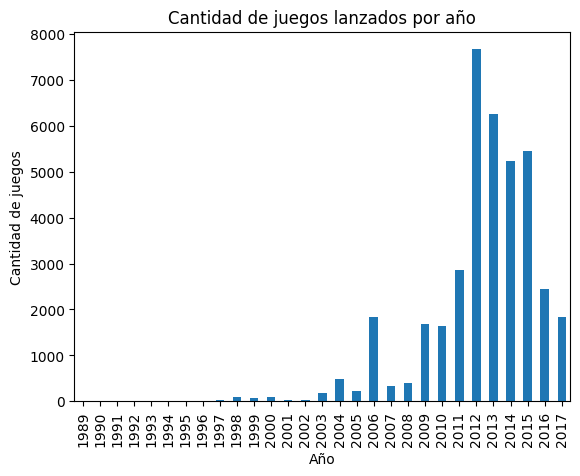

In [14]:
juegosPorAño = df['release_date'].value_counts().sort_index()
juegosPorAño.plot(kind='bar')
plt.title('Cantidad de juegos lanzados por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de juegos')
plt.xticks(rotation=90)
plt.show()

### Analisis de recommend

#### Cantidad de recomendaciones

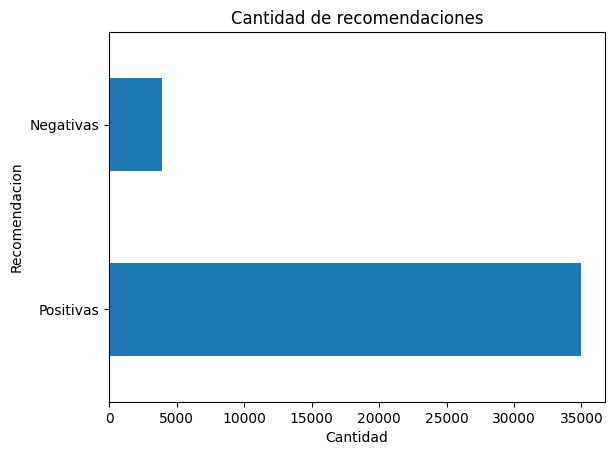

In [15]:
df['recommend'].value_counts().plot(kind='barh')
plt.title('Cantidad de recomendaciones')
plt.xlabel('Cantidad')
plt.ylabel('Recomendacion')
plt.yticks(ticks=[0,1],labels=['Positivas','Negativas'])
plt.show()

#### Top 5 de juegos mas recomendados

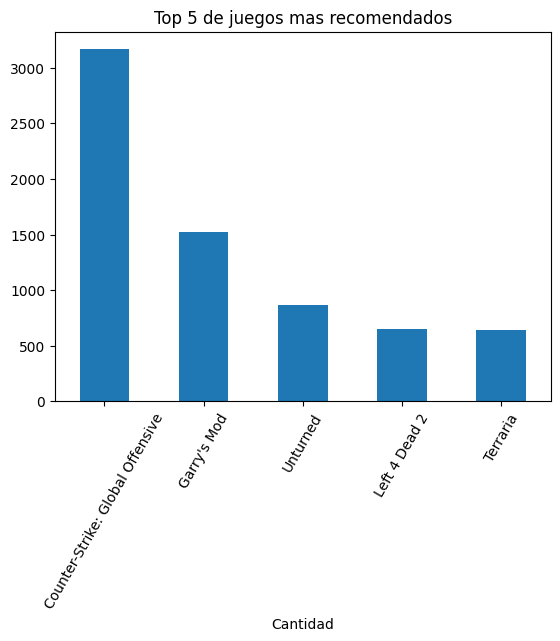

In [16]:
juegosRecomend = df[['item_name', 'recommend']].groupby('item_name')['recommend'].sum().sort_values(ascending=False).head(5)
juegosRecomend.plot(kind='bar')
plt.title('Top 5 de juegos mas recomendados')
plt.xlabel('Cantidad')
plt.xticks(rotation = 60)
plt.show()

### Analisis de sentiment_analysis

#### Cantidad total de sentiment_analysis

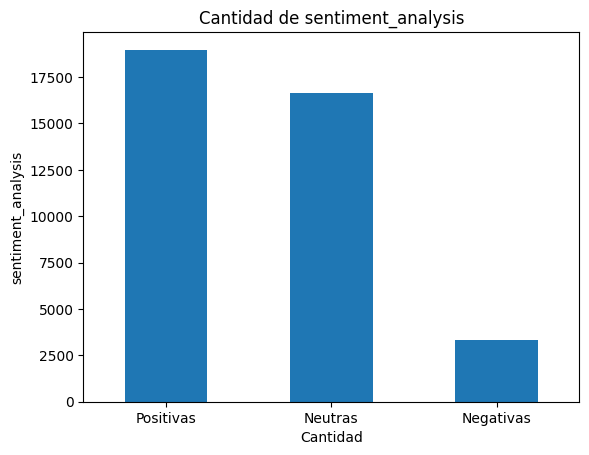

In [17]:
df['sentiment_analysis'].value_counts().plot(kind='bar')
plt.title('Cantidad de sentiment_analysis')
plt.xlabel('Cantidad')
plt.ylabel('sentiment_analysis')
plt.xticks(rotation = 0 ,ticks=[0,1,2],labels=['Positivas','Neutras','Negativas'])
plt.show()

#### Top 5 de juegos con mejor reviws segun segun sentiment_analysis

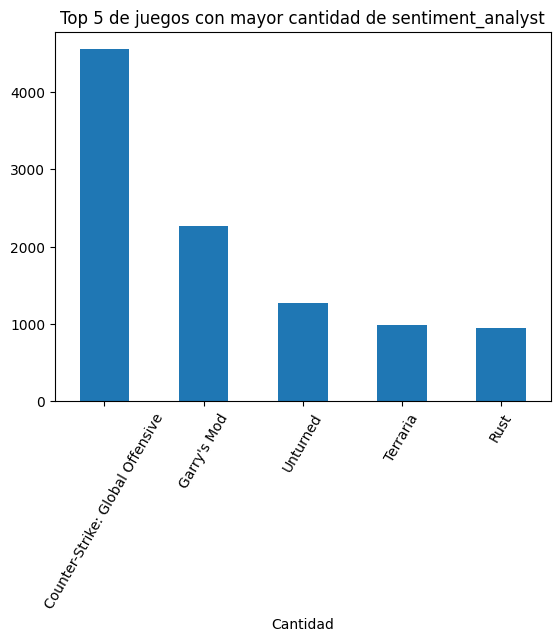

In [19]:
juegosAnalysis = df[['item_name', 'sentiment_analysis']].groupby('item_name')['sentiment_analysis'].sum().sort_values(ascending=False).head(5)
juegosAnalysis.plot(kind='bar')
juegosAnalysis
plt.title('Top 5 de juegos con mayor cantidad de sentiment_analyst')
plt.xlabel('Cantidad')
plt.xticks(rotation = 60)
plt.show()